<a href="https://colab.research.google.com/github/patero22/GNN-Reaserch_project/blob/main/GNN_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Wersja Skryptu na moment 29.06.2024
Zadziała odpalenie komendą run all, jednak to zajmie sporą ilość czasu. Zatem można włączyć wszystkie komórki do momentu "Models" włącznie, a następnie ręcznie uruchomić fragment dotyczący datasetu (poniżej Models), który nas interesuje.

In [1]:
!pip install torch==2.2.1 torchvision torchaudio
!pip install torch-geometric
!pip install dgl==2.1.0
!pip install memory-profiler

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
INFO: pip is looking at multiple versions of torchvision to

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, PNAConv
from dgl.nn.pytorch import GraphConv, GATConv as GATConvDGL, SAGEConv as SAGEConvDGL
from dgl.nn import PNAConv

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
from scipy.sparse import coo_matrix, csr_matrix

# Conversion Functions
def convert_to_coo(edge_index, num_nodes):
    row, col = edge_index
    data = torch.ones(row.size(0))
    coo = coo_matrix((data.numpy(), (row.numpy(), col.numpy())), shape=(num_nodes, num_nodes))
    return coo

def convert_to_csr(edge_index, num_nodes):
    row, col = edge_index
    data = torch.ones(row.size(0))
    csr = csr_matrix((data.numpy(), (row.numpy(), col.numpy())), shape=(num_nodes, num_nodes))
    return csr

In [4]:
# Profiling Function
from memory_profiler import memory_usage
import time

def profile_model(model, data, device, dgl=False, format='coo'):
    data = data.to(device)
    model = model.to(device)

    def forward_pass():
        if dgl:
            model(data, data.ndata['feat'])
        else:
            model(data)

    # Measure time
    start_time = time.time()
    for _ in range(100):
        forward_pass()
    end_time = time.time()

    # Measure peak memory usage
    mem_usage = memory_usage(forward_pass, interval=0.1)

    return (end_time - start_time) / 100, max(mem_usage)

In [5]:
from torch_geometric.datasets import KarateClub, Planetoid
from dgl.data import KarateClubDataset, CiteseerGraphDataset

In [6]:
# Load PyG Datasets
dataset_karate_pyg = KarateClub()
data_karate_pyg = dataset_karate_pyg[0]

dataset_citeseer_pyg = Planetoid(root='data/Citeseer', name='Citeseer')
data_citeseer_pyg = dataset_citeseer_pyg[0]

Processing...
Done!


In [7]:
# Load DGL Datasets
def load_karate_dgl():
    dataset = KarateClubDataset()
    graph = dataset[0]
    return graph

def load_citeseer_dgl():
    dataset = CiteseerGraphDataset()
    graph = dataset[0]
    return graph

graph_karate_dgl = load_karate_dgl()
graph_citeseer_dgl = load_citeseer_dgl()

/root/.dgl/citeseer.zip:   0%|          | 0.00/239k [00:00<?, ?B/s]

Extracting file to /root/.dgl/citeseer_d6836239
Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


### Models

In [8]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
import dgl
from dgl.nn.pytorch import GATConv as GATConvDGL, GraphConv, SAGEConv as SAGEConvDGL, PNAConv as PNAConvDGL

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GCN_DGL(torch.nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN_DGL, self).__init__()
        self.conv1 = GraphConv(in_feats, 16)
        self.conv2 = GraphConv(16, out_feats)

    def forward(self, g, features):
        x = self.conv1(g, features)
        x = F.relu(x)
        x = self.conv2(g, x)
        return x


# Define GAT model for PyG
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = torch_geometric.nn.GATConv(in_channels, 8, heads=8)
        self.conv2 = torch_geometric.nn.GATConv(8 * 8, out_channels, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

# Define GAT model for DGL
class GAT_DGL(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT_DGL, self).__init__()
        self.conv1 = GATConvDGL(in_channels, 8, num_heads=8)
        self.conv2 = GATConvDGL(8 * 8, out_channels, num_heads=1)

    def forward(self, g, features):
        x = self.conv1(g, features).flatten(1)
        x = F.elu(x)
        x = self.conv2(g, x).mean(1)
        return x

# Define GraphSAGE model for PyG
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = torch_geometric.nn.SAGEConv(in_channels, 16, aggr='mean')
        self.conv2 = torch_geometric.nn.SAGEConv(16, out_channels, aggr='mean')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

# Define GraphSAGE model for DGL
class GraphSAGE_DGL(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphSAGE_DGL, self).__init__()
        self.conv1 = SAGEConvDGL(in_channels, 16, aggregator_type='mean')
        self.conv2 = SAGEConvDGL(16, out_channels, aggregator_type='mean')

    def forward(self, g, features):
        x = self.conv1(g, features)
        x = F.elu(x)
        x = self.conv2(g, x)
        return x

# Define PNA model for PyG
# class PNA(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, deg):
#         super(PNA, self).__init__()
#         self.conv1 = torch_geometric.nn.PNAConv(in_channels, 16, aggregators=['mean', 'max', 'min'], scalers=['identity'], deg=deg)
#         self.conv2 = torch_geometric.nn.PNAConv(16, out_channels, aggregators=['mean', 'max', 'min'], scalers=['identity'], deg=deg)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = self.conv2(x, edge_index)
#         return x

# Define PNA model for DGL
# class PNA_DGL(torch.nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(PNA_DGL, self).__init__()
#         self.conv1 = PNAConvDGL(in_channels, 16)
#         self.conv2 = PNAConvDGL(16, out_channels)

#     def forward(self, g, features):
#         x = self.conv1(g, features)
#         x = F.elu(x)
#         x = self.conv2(g, x)
#         return x


### Karate Club & Citeseer Datasets

In [ ]:

# Ensure features and labels are set for DGL graphs
def ensure_dgl_features_and_labels(graph, pyg_data):
    graph.ndata['feat'] = pyg_data.x.clone().detach()
    graph.ndata['label'] = pyg_data.y.clone().detach()
    return graph

graph_karate_dgl = ensure_dgl_features_and_labels(graph_karate_dgl, data_karate_pyg)
graph_citeseer_dgl = ensure_dgl_features_and_labels(graph_citeseer_dgl, data_citeseer_pyg)

# Define devices
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and test models on COO and CSR formats
formats = ['coo', 'csr']
models = {
    'GCN': (GCN, GCN_DGL),
    'GAT': (GAT, GAT_DGL),
    'GraphSAGE': (GraphSAGE, GraphSAGE_DGL),
    #'PNA': (PNA, PNA_DGL)
}

datasets_pyg = {
    'Karate Club': (dataset_karate_pyg, data_karate_pyg),
    'Citeseer': (dataset_citeseer_pyg, data_citeseer_pyg)
}

datasets_dgl = {
    'Karate Club': graph_karate_dgl,
    'Citeseer': graph_citeseer_dgl
}

for model_name, (ModelPyG, ModelDGL) in models.items():
    for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg.items():
        # Calculate degree tensor for PyG PNA model
        if model_name == 'PNA':
            deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
        for fmt in formats:
            if model_name == 'PNA':
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
            else:
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
            time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
            time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

    for dataset_name, graph_dgl in datasets_dgl.items():
        for fmt in formats:
            input_dim = graph_dgl.ndata['feat'].shape[1]
            output_dim = graph_dgl.ndata['label'].max().item() + 1
            model_dgl = ModelDGL(input_dim, output_dim)
            time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
            time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')


PyG Karate Club GCN (COO) on CPU: 0.001713 seconds per iteration, 789.32 MB peak memory
PyG Karate Club GCN (COO) on GPU: 0.002239 seconds per iteration, 789.55 MB peak memory
PyG Karate Club GCN (CSR) on CPU: 0.002474 seconds per iteration, 789.55 MB peak memory
PyG Karate Club GCN (CSR) on GPU: 0.002569 seconds per iteration, 789.56 MB peak memory
PyG Citeseer GCN (COO) on CPU: 0.049556 seconds per iteration, 789.94 MB peak memory
PyG Citeseer GCN (COO) on GPU: 0.027240 seconds per iteration, 789.94 MB peak memory
PyG Citeseer GCN (CSR) on CPU: 0.028986 seconds per iteration, 789.94 MB peak memory
PyG Citeseer GCN (CSR) on GPU: 0.024965 seconds per iteration, 789.94 MB peak memory
DGL Karate Club GCN (COO) on CPU: 0.007588 seconds per iteration, 791.66 MB peak memory
DGL Karate Club GCN (COO) on GPU: 0.007248 seconds per iteration, 791.66 MB peak memory
DGL Karate Club GCN (CSR) on CPU: 0.009329 seconds per iteration, 791.66 MB peak memory
DGL Karate Club GCN (CSR) on GPU: 0.004464 s

### Cora & Pumbed Datasets

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, KarateClub
import dgl
from dgl.data import CoraGraphDataset, CiteseerGraphDataset, PubmedGraphDataset
from dgl.nn.pytorch import GATConv as GATConvDGL, SAGEConv as SAGEConvDGL

In [ ]:
dataset_cora_pyg = Planetoid(root='/tmp/Cora', name='Cora')
data_cora_pyg = dataset_cora_pyg[0]

dataset_pubmed_pyg = Planetoid(root='/tmp/Pubmed', name='Pubmed')
data_pubmed_pyg = dataset_pubmed_pyg[0]

# Load datasets for DGL

graph_cora_dgl = CoraGraphDataset()[0]
graph_cora_dgl = ensure_dgl_features_and_labels(graph_cora_dgl, data_cora_pyg)

graph_pubmed_dgl = PubmedGraphDataset()[0]
graph_pubmed_dgl = ensure_dgl_features_and_labels(graph_pubmed_dgl, data_pubmed_pyg)

# Define devices
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and test models on COO and CSR formats
formats = ['coo', 'csr']
models = {
    'GCN': (GCN, GCN_DGL),
    'GAT': (GAT, GAT_DGL),
    'GraphSAGE': (GraphSAGE, GraphSAGE_DGL),
    #'PNA': (PNA, PNA_DGL)
}

datasets_pyg = {
    'Karate Club': (dataset_karate_pyg, data_karate_pyg),
    'Citeseer': (dataset_citeseer_pyg, data_citeseer_pyg),
    'Cora': (dataset_cora_pyg, data_cora_pyg),
    'Pubmed': (dataset_pubmed_pyg, data_pubmed_pyg)
}

datasets_dgl = {
    'Karate Club': graph_karate_dgl,
    'Citeseer': graph_citeseer_dgl,
    'Cora': graph_cora_dgl,
    'Pubmed': graph_pubmed_dgl
}

for model_name, (ModelPyG, ModelDGL) in models.items():
    for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg.items():
        # Calculate degree tensor for PyG PNA model
        if model_name == 'PNA':
            deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
        for fmt in formats:
            if model_name == 'PNA':
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
            else:
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
            time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
            time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

    for dataset_name, graph_dgl in datasets_dgl.items():
        for fmt in formats:
            input_dim = graph_dgl.ndata['feat'].shape[1]
            output_dim = graph_dgl.ndata['label'].max().item() + 1
            model_dgl = ModelDGL(input_dim, output_dim)
            time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
            time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

Processing...
Done!
Processing...
Done!


/root/.dgl/cora_v2.zip:   0%|          | 0.00/132k [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


/root/.dgl/pubmed.zip:   0%|          | 0.00/4.93M [00:00<?, ?B/s]

Extracting file to /root/.dgl/pubmed_35464cad
Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
PyG Karate Club GCN (COO) on CPU: 0.001388 seconds per iteration, 1003.57 MB peak memory
PyG Karate Club GCN (COO) on GPU: 0.001077 seconds per iteration, 1003.64 MB peak memory
PyG Karate Club GCN (CSR) on CPU: 0.001056 seconds per iteration, 1003.64 MB peak memory
PyG Karate Club GCN (CSR) on GPU: 0.001113 seconds per iteration, 1003.64 MB peak memory
PyG Citeseer GCN (COO) on CPU: 0.015253 seconds per iteration, 1003.66 MB peak memory
PyG Citeseer GCN (COO) on GPU: 0.015211 seconds per iteration, 1003.66 MB peak memory
PyG Citeseer GCN (CSR) on CPU: 0.014787 seconds per iteration, 1003.66 MB peak memory
PyG Citeseer GCN (CSR) on GPU: 0.017467 seconds per iteration, 1003.66 MB peak memory
PyG Cora GCN (COO) on CPU: 0.0110

### AmazonComputers Dataset
correct





In [9]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, KarateClub, Amazon, Coauthor, PPI, Reddit, Flickr
import dgl
from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset, PPIDataset, RedditDataset, FlickrDataset
from dgl.nn.pytorch import GATConv as GATConvDGL, SAGEConv as SAGEConvDGL

# Load datasets for PyG
dataset_amazon_computers_pyg = Amazon(root='/tmp/AmazonComputers', name='Computers')
data_amazon_computers_pyg = dataset_amazon_computers_pyg[0]
# Load datasets for DGL
graph_amazon_computers_dgl = dgl.graph((data_amazon_computers_pyg.edge_index[0], data_amazon_computers_pyg.edge_index[1]))

# Ensure features and labels are set for DGL graphs
def ensure_dgl_features_and_labels(graph, pyg_data):
    graph.ndata['feat'] = pyg_data.x.clone().detach()
    graph.ndata['label'] = pyg_data.y.clone().detach()
    return graph

graph_amazon_computers_dgl = ensure_dgl_features_and_labels(graph_amazon_computers_dgl, data_amazon_computers_pyg)

# Add self-loops to the DGL graphs to handle 0-in-degree nodes
graphs_dgl = {
    'Amazon Computers': graph_amazon_computers_dgl
}

for name, graph in graphs_dgl.items():
    graphs_dgl[name] = dgl.add_self_loop(graph)

datasets_pyg_amazon_computers = {
    'Amazon Computers': (dataset_amazon_computers_pyg, data_amazon_computers_pyg)
}

datasets_dgl_amazon_computers = {
    'Amazon Computers': graphs_dgl['Amazon Computers']
}

Processing...
Done!


In [10]:
# Define devices
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and test models on COO and CSR formats
formats = ['coo', 'csr']
models = {
    'GCN': (GCN, GCN_DGL),
    'GAT': (GAT, GAT_DGL),
    'GraphSAGE': (GraphSAGE, GraphSAGE_DGL),
    #'PNA': (PNA, PNA_DGL)
}

for model_name, (ModelPyG, ModelDGL) in models.items():
    for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg_amazon_computers.items():
        # Calculate degree tensor for PyG PNA model
        if model_name == 'PNA':
            deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
        for fmt in formats:
            if model_name == 'PNA':
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
            else:
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
            time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
            time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

    for dataset_name, graph_dgl in datasets_dgl_amazon_computers.items():
        for fmt in formats:
            input_dim = graph_dgl.ndata['feat'].shape[1]
            output_dim = graph_dgl.ndata['label'].max().item() + 1
            model_dgl = ModelDGL(input_dim, output_dim)
            time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
            time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

PyG Amazon Computers GCN (COO) on CPU: 0.434184 seconds per iteration, 983.45 MB peak memory
PyG Amazon Computers GCN (COO) on GPU: 0.221872 seconds per iteration, 983.98 MB peak memory
PyG Amazon Computers GCN (CSR) on CPU: 0.209294 seconds per iteration, 1003.29 MB peak memory
PyG Amazon Computers GCN (CSR) on GPU: 0.222873 seconds per iteration, 1022.50 MB peak memory
DGL Amazon Computers GCN (COO) on CPU: 0.046163 seconds per iteration, 1024.16 MB peak memory
DGL Amazon Computers GCN (COO) on GPU: 0.045998 seconds per iteration, 1024.18 MB peak memory
DGL Amazon Computers GCN (CSR) on CPU: 0.043364 seconds per iteration, 1024.18 MB peak memory
DGL Amazon Computers GCN (CSR) on GPU: 0.045657 seconds per iteration, 1024.18 MB peak memory
PyG Amazon Computers GAT (COO) on CPU: 0.679151 seconds per iteration, 1407.51 MB peak memory
PyG Amazon Computers GAT (COO) on GPU: 0.738053 seconds per iteration, 1415.23 MB peak memory
PyG Amazon Computers GAT (CSR) on CPU: 0.713294 seconds per it

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to visualize a graph using NetworkX and Matplotlib
def visualize_graph(edge_index, num_nodes, title="Graph Visualization"):
    G = nx.Graph()
    edges = edge_index.t().tolist()
    G.add_edges_from(edges)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=50, node_color='blue', edge_color='gray', with_labels=False)
    plt.title(title)
    plt.show()

# Extract the edge index and number of nodes from the AmazonComputers dataset for visualization
edge_index_amazon = data_amazon_computers_pyg.edge_index
num_nodes_amazon = data_amazon_computers_pyg.num_nodes

# Visualize the AmazonComputers graph
visualize_graph(edge_index_amazon, num_nodes_amazon, title="AmazonComputers Graph")

KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

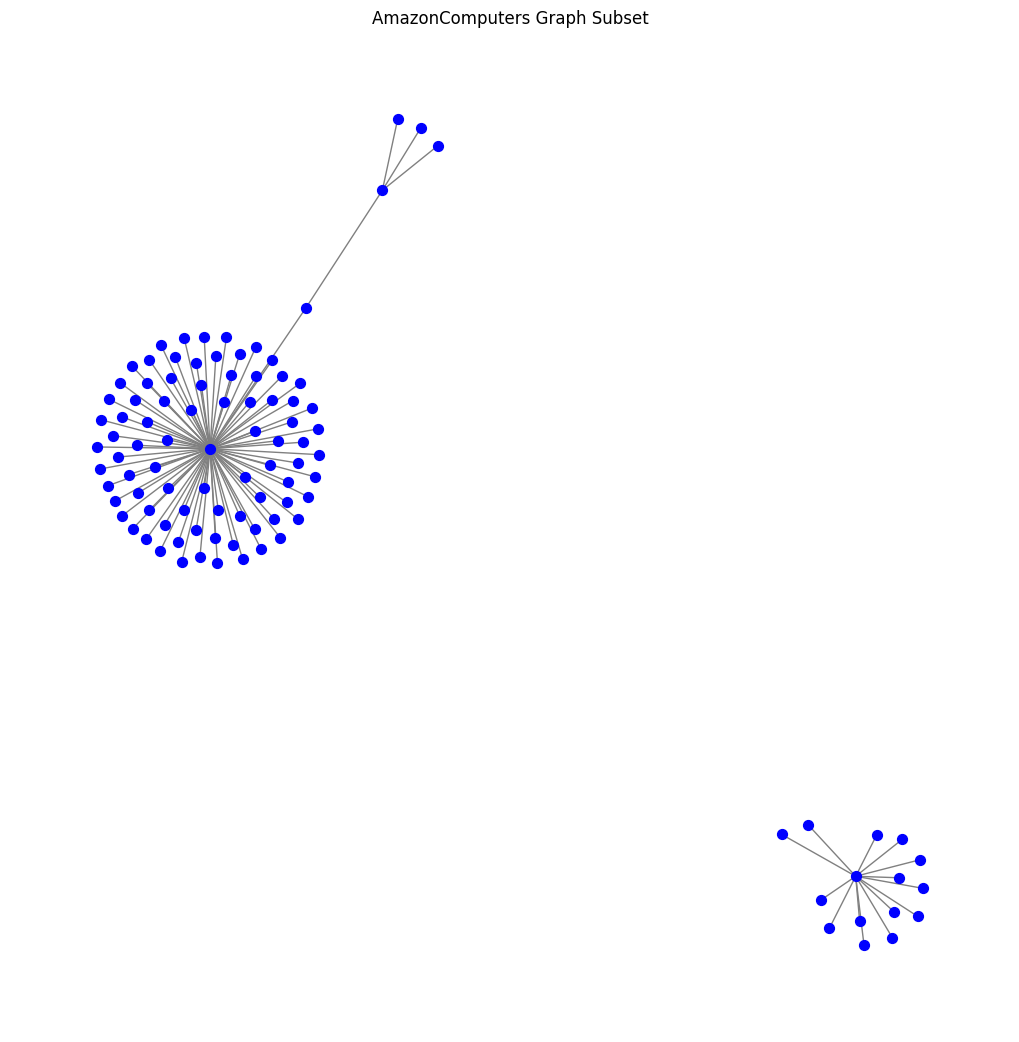

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to visualize a subset of the graph using NetworkX and Matplotlib
def visualize_graph_subset(edge_index, num_nodes, subset_size=100, title="Graph Visualization"):
    G = nx.Graph()
    edges = edge_index.t().tolist()
    G.add_edges_from(edges[:subset_size])

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=50, node_color='blue', edge_color='gray', with_labels=False)
    plt.title(title)
    plt.show()

# Extract the edge index and number of nodes from the AmazonComputers dataset for visualization
edge_index_amazon = data_amazon_computers_pyg.edge_index
num_nodes_amazon = data_amazon_computers_pyg.num_nodes

# Visualize a subset of the AmazonComputers graph
visualize_graph_subset(edge_index_amazon, num_nodes_amazon, subset_size=100, title="AmazonComputers Graph Subset")


### Amazon Photo Dataset

> *correct*



In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, KarateClub, Amazon, Coauthor, PPI, Reddit, Flickr
import dgl
from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset, PPIDataset, RedditDataset, FlickrDataset
from dgl.nn.pytorch import GATConv as GATConvDGL, SAGEConv as SAGEConvDGL

# Load datasets for PyG
dataset_amazon_photo_pyg = Amazon(root='/tmp/AmazonPhoto', name='Photo')
data_amazon_photo_pyg = dataset_amazon_photo_pyg[0]
# Load datasets for DGL
graph_amazon_photo_dgl = dgl.graph((data_amazon_photo_pyg.edge_index[0], data_amazon_photo_pyg.edge_index[1]))

# Ensure features and labels are set for DGL graphs
def ensure_dgl_features_and_labels(graph, pyg_data):
    graph.ndata['feat'] = pyg_data.x.clone().detach()
    graph.ndata['label'] = pyg_data.y.clone().detach()
    return graph

graph_amazon_photo_dgl = ensure_dgl_features_and_labels(graph_amazon_photo_dgl, data_amazon_photo_pyg)


# Add self-loops to the DGL graphs to handle 0-in-degree nodes
graphs_dgl = {
    'Amazon Photo': graph_amazon_photo_dgl
}

for name, graph in graphs_dgl.items():
    graphs_dgl[name] = dgl.add_self_loop(graph)

datasets_pyg_amazon_photo = {
    'Amazon Photo': (dataset_amazon_photo_pyg, data_amazon_photo_pyg),
}

datasets_dgl_amazon_photo = {
    'Amazon Photo': graphs_dgl['Amazon Photo'],
}

Processing...
Done!


In [ ]:
# Define devices
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and test models on COO and CSR formats
formats = ['coo', 'csr']
models = {
    'GCN': (GCN, GCN_DGL),
    'GAT': (GAT, GAT_DGL),
    'GraphSAGE': (GraphSAGE, GraphSAGE_DGL),
    #'PNA': (PNA, PNA_DGL)
}

for model_name, (ModelPyG, ModelDGL) in models.items():
    for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg_amazon_photo.items():
        # Calculate degree tensor for PyG PNA model
        if model_name == 'PNA':
            deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
        for fmt in formats:
            if model_name == 'PNA':
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
            else:
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
            time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
            time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

    for dataset_name, graph_dgl in datasets_dgl_amazon_photo.items():
        for fmt in formats:
            input_dim = graph_dgl.ndata['feat'].shape[1]
            output_dim = graph_dgl.ndata['label'].max().item() + 1
            model_dgl = ModelDGL(input_dim, output_dim)
            time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
            time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

PyG Amazon Photo GCN (COO) on CPU: 0.057477 seconds per iteration, 1229.47 MB peak memory
PyG Amazon Photo GCN (COO) on GPU: 0.067181 seconds per iteration, 1229.47 MB peak memory
PyG Amazon Photo GCN (CSR) on CPU: 0.056480 seconds per iteration, 1233.22 MB peak memory
PyG Amazon Photo GCN (CSR) on GPU: 0.066257 seconds per iteration, 1233.22 MB peak memory
DGL Amazon Photo GCN (COO) on CPU: 0.014886 seconds per iteration, 1233.23 MB peak memory
DGL Amazon Photo GCN (COO) on GPU: 0.015296 seconds per iteration, 1233.23 MB peak memory
DGL Amazon Photo GCN (CSR) on CPU: 0.014437 seconds per iteration, 1233.23 MB peak memory
DGL Amazon Photo GCN (CSR) on GPU: 0.014950 seconds per iteration, 1233.23 MB peak memory
PyG Amazon Photo GAT (COO) on CPU: 0.250965 seconds per iteration, 1334.38 MB peak memory
PyG Amazon Photo GAT (COO) on GPU: 0.254036 seconds per iteration, 1401.88 MB peak memory
PyG Amazon Photo GAT (CSR) on CPU: 0.248051 seconds per iteration, 1355.02 MB peak memory
PyG Amazon

### CoauthorCS Dataset

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, KarateClub, Amazon, Coauthor, PPI, Reddit, Flickr
import dgl
from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset, PPIDataset, RedditDataset, FlickrDataset
from dgl.nn.pytorch import GATConv as GATConvDGL, SAGEConv as SAGEConvDGL

# Load datasets for PyG
dataset_coauthor_cs_pyg = Coauthor(root='/tmp/CoauthorCS', name='CS')
data_coauthor_cs_pyg = dataset_coauthor_cs_pyg[0]
# Load datasets for DGL
graph_coauthor_cs_dgl = dgl.graph((data_coauthor_cs_pyg.edge_index[0], data_coauthor_cs_pyg.edge_index[1]))

# Ensure features and labels are set for DGL graphs
def ensure_dgl_features_and_labels(graph, pyg_data):
    graph.ndata['feat'] = pyg_data.x.clone().detach()
    graph.ndata['label'] = pyg_data.y.clone().detach()
    return graph

graph_coauthor_cs_dgl = ensure_dgl_features_and_labels(graph_coauthor_cs_dgl, data_coauthor_cs_pyg)

# Add self-loops to the DGL graphs to handle 0-in-degree nodes
graphs_dgl = {
    'Coauthor CS': graph_coauthor_cs_dgl
}

for name, graph in graphs_dgl.items():
    graphs_dgl[name] = dgl.add_self_loop(graph)

datasets_pyg_CoauthorCS = {
    'Coauthor CS': (dataset_coauthor_cs_pyg, data_coauthor_cs_pyg)
}

datasets_dgl_CoauthorCS = {
    'Coauthor CS': graphs_dgl['Coauthor CS']
}

Processing...
Done!


In [ ]:
# Define devices
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and test models on COO and CSR formats
formats = ['coo', 'csr']
models = {
    'GCN': (GCN, GCN_DGL),
    'GAT': (GAT, GAT_DGL),
    'GraphSAGE': (GraphSAGE, GraphSAGE_DGL),
    #'PNA': (PNA, PNA_DGL)
}

for model_name, (ModelPyG, ModelDGL) in models.items():
    for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg_CoauthorCS.items():
        # Calculate degree tensor for PyG PNA model
        if model_name == 'PNA':
            deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
        for fmt in formats:
            if model_name == 'PNA':
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
            else:
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
            time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
            time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

    for dataset_name, graph_dgl in datasets_dgl_CoauthorCS.items():
        for fmt in formats:
            input_dim = graph_dgl.ndata['feat'].shape[1]
            output_dim = graph_dgl.ndata['label'].max().item() + 1
            model_dgl = ModelDGL(input_dim, output_dim)
            time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
            time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

PyG Coauthor CS GCN (COO) on CPU: 0.217588 seconds per iteration, 2176.52 MB peak memory
PyG Coauthor CS GCN (COO) on GPU: 0.209270 seconds per iteration, 2177.20 MB peak memory
PyG Coauthor CS GCN (CSR) on CPU: 0.216145 seconds per iteration, 2182.22 MB peak memory
PyG Coauthor CS GCN (CSR) on GPU: 0.214661 seconds per iteration, 2182.22 MB peak memory
DGL Coauthor CS GCN (COO) on CPU: 0.523091 seconds per iteration, 2658.14 MB peak memory
DGL Coauthor CS GCN (COO) on GPU: 0.518473 seconds per iteration, 2658.14 MB peak memory
DGL Coauthor CS GCN (CSR) on CPU: 0.518867 seconds per iteration, 2658.14 MB peak memory
DGL Coauthor CS GCN (CSR) on GPU: 0.517603 seconds per iteration, 2658.14 MB peak memory
PyG Coauthor CS GAT (COO) on CPU: 0.662686 seconds per iteration, 2300.36 MB peak memory
PyG Coauthor CS GAT (COO) on GPU: 0.611579 seconds per iteration, 2297.83 MB peak memory
PyG Coauthor CS GAT (CSR) on CPU: 0.605397 seconds per iteration, 2303.25 MB peak memory
PyG Coauthor CS GAT (


### Coauthor Physics Dataset

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, KarateClub, Amazon, Coauthor, PPI, Reddit, Flickr
import dgl
from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset, PPIDataset, RedditDataset, FlickrDataset
from dgl.nn.pytorch import GATConv as GATConvDGL, SAGEConv as SAGEConvDGL

# Load datasets for PyG
dataset_coauthor_physics_pyg = Coauthor(root='/tmp/CoauthorPhysics', name='Physics')
data_coauthor_physics_pyg = dataset_coauthor_physics_pyg[0]
# Load datasets for DGL
graph_coauthor_physics_dgl = dgl.graph((data_coauthor_physics_pyg.edge_index[0], data_coauthor_physics_pyg.edge_index[1]))

# Ensure features and labels are set for DGL graphs
def ensure_dgl_features_and_labels(graph, pyg_data):
    graph.ndata['feat'] = pyg_data.x.clone().detach()
    graph.ndata['label'] = pyg_data.y.clone().detach()
    return graph

graph_coauthor_physics_dgl = ensure_dgl_features_and_labels(graph_coauthor_physics_dgl, data_coauthor_physics_pyg)

# Add self-loops to the DGL graphs to handle 0-in-degree nodes
graphs_dgl = {
    'Coauthor Physics': graph_coauthor_physics_dgl
}

for name, graph in graphs_dgl.items():
    graphs_dgl[name] = dgl.add_self_loop(graph)

datasets_pyg_CoauthorPh = {
    'Coauthor Physics': (dataset_coauthor_physics_pyg, data_coauthor_physics_pyg)
}

datasets_dgl_CoauthorPh = {
    'Coauthor Physics': graphs_dgl['Coauthor Physics']
}

In [ ]:
# Define devices
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and test models on COO and CSR formats
formats = ['coo', 'csr']
models = {
    'GCN': (GCN, GCN_DGL),
    'GAT': (GAT, GAT_DGL),
    'GraphSAGE': (GraphSAGE, GraphSAGE_DGL),
    #'PNA': (PNA, PNA_DGL)
}

for model_name, (ModelPyG, ModelDGL) in models.items():
    for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg_CoauthorPh.items():
        # Calculate degree tensor for PyG PNA model
        if model_name == 'PNA':
            deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
        for fmt in formats:
            if model_name == 'PNA':
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
            else:
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
            time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
            time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

    for dataset_name, graph_dgl in datasets_dgl_CoauthorPh.items():
        for fmt in formats:
            input_dim = graph_dgl.ndata['feat'].shape[1]
            output_dim = graph_dgl.ndata['label'].max().item() + 1
            model_dgl = ModelDGL(input_dim, output_dim)
            time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
            time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

### PPI Dataset
  

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, KarateClub, Amazon, Coauthor, PPI, Reddit, Flickr
import dgl
from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset, PPIDataset, RedditDataset, FlickrDataset
from dgl.nn.pytorch import GATConv as GATConvDGL, SAGEConv as SAGEConvDGL

# Load datasets for PyG
dataset_ppi_pyg = PPI(root='/tmp/PPI')
data_ppi_pyg = dataset_ppi_pyg[0]
# Load datasets for DGL
graph_ppi_dgl = PPIDataset()[0]

# Ensure features and labels are set for DGL graphs
def ensure_dgl_features_and_labels(graph, pyg_data):
    graph.ndata['feat'] = pyg_data.x.clone().detach()
    graph.ndata['label'] = pyg_data.y.clone().detach()
    return graph

graph_ppi_dgl = ensure_dgl_features_and_labels(graph_ppi_dgl, data_ppi_pyg)


# Add self-loops to the DGL graphs to handle 0-in-degree nodes
graphs_dgl = {
       'PPI': graph_ppi_dgl
}

for name, graph in graphs_dgl.items():
    graphs_dgl[name] = dgl.add_self_loop(graph)

datasets_pyg_PPI = {
    'PPI': (dataset_ppi_pyg, data_ppi_pyg)
}

datasets_dgl_PPI = {
    'PPI': graphs_dgl['PPI']
}

In [ ]:
# Define devices
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and test models on COO and CSR formats
formats = ['coo', 'csr']
models = {
    'GCN': (GCN, GCN_DGL),
    'GAT': (GAT, GAT_DGL),
    'GraphSAGE': (GraphSAGE, GraphSAGE_DGL),
    #'PNA': (PNA, PNA_DGL)
}

for model_name, (ModelPyG, ModelDGL) in models.items():
    for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg_PPI.items():
        # Calculate degree tensor for PyG PNA model
        if model_name == 'PNA':
            deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
        for fmt in formats:
            if model_name == 'PNA':
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
            else:
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
            time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
            time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

    for dataset_name, graph_dgl in datasets_dgl_PPI.items():
        for fmt in formats:
            input_dim = graph_dgl.ndata['feat'].shape[1]
            # Ensure output_dim is an integer by converting it explicitly
            output_dim = int(graph_dgl.ndata['label'].max().item() + 1)
            model_dgl = ModelDGL(input_dim, output_dim)
            time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
            time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

PyG PPI GCN (COO) on CPU: 0.024176 seconds per iteration, 2220.48 MB peak memory
PyG PPI GCN (COO) on GPU: 0.019978 seconds per iteration, 2220.48 MB peak memory
PyG PPI GCN (CSR) on CPU: 0.019826 seconds per iteration, 2220.51 MB peak memory
PyG PPI GCN (CSR) on GPU: 0.020162 seconds per iteration, 2220.51 MB peak memory
DGL PPI GCN (COO) on CPU: 0.003009 seconds per iteration, 2220.52 MB peak memory
DGL PPI GCN (COO) on GPU: 0.003114 seconds per iteration, 2220.52 MB peak memory
DGL PPI GCN (CSR) on CPU: 0.003013 seconds per iteration, 2220.52 MB peak memory
DGL PPI GCN (CSR) on GPU: 0.004037 seconds per iteration, 2220.52 MB peak memory
PyG PPI GAT (COO) on CPU: 0.041422 seconds per iteration, 2220.52 MB peak memory
PyG PPI GAT (COO) on GPU: 0.034191 seconds per iteration, 2220.52 MB peak memory
PyG PPI GAT (CSR) on CPU: 0.034003 seconds per iteration, 2220.52 MB peak memory
PyG PPI GAT (CSR) on GPU: 0.042786 seconds per iteration, 2220.52 MB peak memory
DGL PPI GAT (COO) on CPU: 0.

### Flickr Dataset

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, KarateClub, Amazon, Coauthor, PPI, Reddit, Flickr
import dgl
from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset, PPIDataset, RedditDataset, FlickrDataset
from dgl.nn.pytorch import GATConv as GATConvDGL, SAGEConv as SAGEConvDGL

# Load datasets for PyG
dataset_flickr_pyg = Flickr(root='/tmp/Flickr')
data_flickr_pyg = dataset_flickr_pyg[0]
# Load datasets for DGL
graph_flickr_dgl = FlickrDataset()[0]
# Ensure features and labels are set for DGL graphs
def ensure_dgl_features_and_labels(graph, pyg_data):
    graph.ndata['feat'] = pyg_data.x.clone().detach()
    graph.ndata['label'] = pyg_data.y.clone().detach()
    return graph

graph_flickr_dgl = ensure_dgl_features_and_labels(graph_flickr_dgl, data_flickr_pyg)

# Add self-loops to the DGL graphs to handle 0-in-degree nodes
graphs_dgl = {
    'Flickr': graph_flickr_dgl
}

for name, graph in graphs_dgl.items():
    graphs_dgl[name] = dgl.add_self_loop(graph)

datasets_pyg_Flickr = {
    'Flickr': (dataset_flickr_pyg, data_flickr_pyg)
}

datasets_dgl_Flickr = {
    'Flickr': graphs_dgl['Flickr']
}

In [ ]:
# Define devices
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and test models on COO and CSR formats
formats = ['coo', 'csr']
models = {
    'GCN': (GCN, GCN_DGL),
    'GAT': (GAT, GAT_DGL),
    'GraphSAGE': (GraphSAGE, GraphSAGE_DGL),
    #'PNA': (PNA, PNA_DGL)
}

for model_name, (ModelPyG, ModelDGL) in models.items():
    for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg_Flickr.items():
        # Calculate degree tensor for PyG PNA model
        if model_name == 'PNA':
            deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
        for fmt in formats:
            if model_name == 'PNA':
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
            else:
                model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
            time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
            time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

    for dataset_name, graph_dgl in datasets_dgl_Flickr.items():
        for fmt in formats:
            input_dim = graph_dgl.ndata['feat'].shape[1]
            output_dim = graph_dgl.ndata['label'].max().item() + 1
            model_dgl = ModelDGL(input_dim, output_dim)
            time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
            time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
            print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

PyG Flickr GCN (COO) on CPU: 0.453149 seconds per iteration, 1944.08 MB peak memory
PyG Flickr GCN (COO) on GPU: 0.422186 seconds per iteration, 1989.38 MB peak memory
PyG Flickr GCN (CSR) on CPU: 0.402963 seconds per iteration, 2004.48 MB peak memory
PyG Flickr GCN (CSR) on GPU: 0.524183 seconds per iteration, 2042.05 MB peak memory
DGL Flickr GCN (COO) on CPU: 0.234095 seconds per iteration, 2056.00 MB peak memory
DGL Flickr GCN (COO) on GPU: 0.238745 seconds per iteration, 2056.02 MB peak memory
DGL Flickr GCN (CSR) on CPU: 0.232657 seconds per iteration, 2056.08 MB peak memory
DGL Flickr GCN (CSR) on GPU: 0.232186 seconds per iteration, 2056.08 MB peak memory
PyG Flickr GAT (COO) on CPU: 1.349697 seconds per iteration, 2784.97 MB peak memory
PyG Flickr GAT (COO) on GPU: 1.323429 seconds per iteration, 2767.50 MB peak memory
PyG Flickr GAT (CSR) on CPU: 1.321054 seconds per iteration, 2824.25 MB peak memory
PyG Flickr GAT (CSR) on GPU: 1.395938 seconds per iteration, 2809.91 MB peak

## DATASETS INFORMATIONS

In [ ]:
import torch
import torch_geometric
from torch_geometric.datasets import Amazon, Coauthor, PPI, Flickr
import dgl
from dgl.data import PPIDataset, FlickrDataset

# Load datasets for PyG
dataset_amazon_computers_pyg = Amazon(root='/tmp/AmazonComputers', name='Computers')
data_amazon_computers_pyg = dataset_amazon_computers_pyg[0]

dataset_amazon_photo_pyg = Amazon(root='/tmp/AmazonPhoto', name='Photo')
data_amazon_photo_pyg = dataset_amazon_photo_pyg[0]

dataset_coauthor_cs_pyg = Coauthor(root='/tmp/CoauthorCS', name='CS')
data_coauthor_cs_pyg = dataset_coauthor_cs_pyg[0]

dataset_coauthor_physics_pyg = Coauthor(root='/tmp/CoauthorPhysics', name='Physics')
data_coauthor_physics_pyg = dataset_coauthor_physics_pyg[0]

dataset_ppi_pyg = PPI(root='/tmp/PPI')
data_ppi_pyg = dataset_ppi_pyg[0]

dataset_flickr_pyg = Flickr(root='/tmp/Flickr')
data_flickr_pyg = dataset_flickr_pyg[0]

# Load datasets for DGL
graph_amazon_computers_dgl = dgl.graph((data_amazon_computers_pyg.edge_index[0], data_amazon_computers_pyg.edge_index[1]))
graph_amazon_photo_dgl = dgl.graph((data_amazon_photo_pyg.edge_index[0], data_amazon_photo_pyg.edge_index[1]))
graph_coauthor_cs_dgl = dgl.graph((data_coauthor_cs_pyg.edge_index[0], data_coauthor_cs_pyg.edge_index[1]))
graph_coauthor_physics_dgl = dgl.graph((data_coauthor_physics_pyg.edge_index[0], data_coauthor_physics_pyg.edge_index[1]))
graph_ppi_dgl = PPIDataset()[0]
graph_flickr_dgl = FlickrDataset()[0]

# Ensure features and labels are set for DGL graphs
def ensure_dgl_features_and_labels(graph, pyg_data):
    graph.ndata['feat'] = pyg_data.x.clone().detach()
    graph.ndata['label'] = pyg_data.y.clone().detach()
    return graph

graph_amazon_computers_dgl = ensure_dgl_features_and_labels(graph_amazon_computers_dgl, data_amazon_computers_pyg)
graph_amazon_photo_dgl = ensure_dgl_features_and_labels(graph_amazon_photo_dgl, data_amazon_photo_pyg)
graph_coauthor_cs_dgl = ensure_dgl_features_and_labels(graph_coauthor_cs_dgl, data_coauthor_cs_pyg)
graph_coauthor_physics_dgl = ensure_dgl_features_and_labels(graph_coauthor_physics_dgl, data_coauthor_physics_pyg)
graph_ppi_dgl = ensure_dgl_features_and_labels(graph_ppi_dgl, data_ppi_pyg)
graph_flickr_dgl = ensure_dgl_features_and_labels(graph_flickr_dgl, data_flickr_pyg)

# Add self-loops to the DGL graphs to handle 0-in-degree nodes
graphs_dgl = {
    'Amazon Computers': graph_amazon_computers_dgl,
    'Amazon Photo': graph_amazon_photo_dgl,
    'Coauthor CS': graph_coauthor_cs_dgl,
    'Coauthor Physics': graph_coauthor_physics_dgl,
    'PPI': graph_ppi_dgl,
    'Flickr': graph_flickr_dgl
}

for name, graph in graphs_dgl.items():
    graphs_dgl[name] = dgl.add_self_loop(graph)

# Print dataset information
def print_pyg_dataset_info(name, dataset, data):
    print(f"PyG {name} Dataset:")
    print(f"  Number of nodes: {data.num_nodes}")
    print(f"  Number of edges: {data.num_edges // 2}")  # edges are doubled
    print(f"  Number of features: {dataset.num_features}")
    print(f"  Number of classes: {dataset.num_classes}")
    print(f"  Edge index shape: {data.edge_index.shape}")
    print(f"  Features shape: {data.x.shape}")
    print(f"  Labels shape: {data.y.shape}\n")

def print_dgl_dataset_info(name, graph):
    print(f"DGL {name} Dataset:")
    print(f"  Number of nodes: {graph.num_nodes()}")
    print(f"  Number of edges: {graph.num_edges() // 2}")  # edges are doubled
    print(f"  Number of features: {graph.ndata['feat'].shape[1]}")
    print(f"  Number of classes: {len(torch.unique(graph.ndata['label']))}")
    print(f"  Edge index shape: {graph.edges(form='all')[0].shape}")
    print(f"  Features shape: {graph.ndata['feat'].shape}")
    print(f"  Labels shape: {graph.ndata['label'].shape}\n")

# Print information for PyG datasets
datasets_pyg = {
    'Amazon Computers': (dataset_amazon_computers_pyg, data_amazon_computers_pyg),
    'Amazon Photo': (dataset_amazon_photo_pyg, data_amazon_photo_pyg),
    'Coauthor CS': (dataset_coauthor_cs_pyg, data_coauthor_cs_pyg),
    'Coauthor Physics': (dataset_coauthor_physics_pyg, data_coauthor_physics_pyg),
    'PPI': (dataset_ppi_pyg, data_ppi_pyg),
    'Flickr': (dataset_flickr_pyg, data_flickr_pyg)
}

for name, (dataset, data) in datasets_pyg.items():
    print_pyg_dataset_info(name, dataset, data)

# Print information for DGL datasets
datasets_dgl = {
    'Amazon Computers': graphs_dgl['Amazon Computers'],
    'Amazon Photo': graphs_dgl['Amazon Photo'],
    'Coauthor CS': graphs_dgl['Coauthor CS'],
    'Coauthor Physics': graphs_dgl['Coauthor Physics'],
    'PPI': graphs_dgl['PPI'],
    'Flickr': graphs_dgl['Flickr']
}

for name, graph in datasets_dgl.items():
    print_dgl_dataset_info(name, graph)


PyG Amazon Computers Dataset:
  Number of nodes: 13752
  Number of edges: 245861
  Number of features: 767
  Number of classes: 10
  Edge index shape: torch.Size([2, 491722])
  Features shape: torch.Size([13752, 767])
  Labels shape: torch.Size([13752])

PyG Amazon Photo Dataset:
  Number of nodes: 7650
  Number of edges: 119081
  Number of features: 745
  Number of classes: 8
  Edge index shape: torch.Size([2, 238162])
  Features shape: torch.Size([7650, 745])
  Labels shape: torch.Size([7650])

PyG Coauthor CS Dataset:
  Number of nodes: 18333
  Number of edges: 81894
  Number of features: 6805
  Number of classes: 15
  Edge index shape: torch.Size([2, 163788])
  Features shape: torch.Size([18333, 6805])
  Labels shape: torch.Size([18333])

PyG Coauthor Physics Dataset:
  Number of nodes: 34493
  Number of edges: 247962
  Number of features: 8415
  Number of classes: 5
  Edge index shape: torch.Size([2, 495924])
  Features shape: torch.Size([34493, 8415])
  Labels shape: torch.Size([

# Previous code versions

In [ ]:
# # Define devices
# device_cpu = torch.device('cpu')
# device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# # Define and test models on COO and CSR formats
# formats = ['coo', 'csr']
# models = {
#     'GCN': (GCN, GCN_DGL),
#     'GAT': (GAT, GAT_DGL),
#     'GraphSAGE': (GraphSAGE, GraphSAGE_DGL),
#     #'PNA': (PNA, PNA_DGL)
# }

# for model_name, (ModelPyG, ModelDGL) in models.items():
#     for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg.items():
#         # Calculate degree tensor for PyG PNA model
#         if model_name == 'PNA':
#             deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
#         for fmt in formats:
#             if model_name == 'PNA':
#                 model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
#             else:
#                 model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
#             time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
#             time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
#             print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
#             print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

#     for dataset_name, graph_dgl in datasets_dgl.items():
#         for fmt in formats:
#             input_dim = graph_dgl.ndata['feat'].shape[1]
#             output_dim = graph_dgl.ndata['label'].max().item() + 1
#             model_dgl = ModelDGL(input_dim, output_dim)
#             time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
#             time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
#             print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
#             print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')


PyG Amazon Computers GCN (COO) on CPU: 0.211223 seconds per iteration, 5105.08 MB peak memory
PyG Amazon Computers GCN (COO) on GPU: 0.187418 seconds per iteration, 5105.54 MB peak memory
PyG Amazon Computers GCN (CSR) on CPU: 0.170395 seconds per iteration, 5124.83 MB peak memory
PyG Amazon Computers GCN (CSR) on GPU: 0.184569 seconds per iteration, 5105.34 MB peak memory
PyG Amazon Photo GCN (COO) on CPU: 0.067607 seconds per iteration, 5105.49 MB peak memory
PyG Amazon Photo GCN (COO) on GPU: 0.069725 seconds per iteration, 5105.53 MB peak memory
PyG Amazon Photo GCN (CSR) on CPU: 0.061381 seconds per iteration, 5039.46 MB peak memory
PyG Amazon Photo GCN (CSR) on GPU: 0.071416 seconds per iteration, 5039.46 MB peak memory
PyG Coauthor CS GCN (COO) on CPU: 0.231826 seconds per iteration, 5052.44 MB peak memory
PyG Coauthor CS GCN (COO) on GPU: 0.229854 seconds per iteration, 5052.44 MB peak memory
PyG Coauthor CS GCN (CSR) on CPU: 0.226484 seconds per iteration, 5073.97 MB peak memo

TypeError: new(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got float"

In [ ]:
# dataset_amazon_computers_pyg = Amazon(root='/tmp/AmazonComputers', name='Computers')
# data_amazon_computers_pyg = dataset_amazon_computers_pyg[0]

# dataset_amazon_photo_pyg = Amazon(root='/tmp/AmazonPhoto', name='Photo')
# data_amazon_photo_pyg = dataset_amazon_photo_pyg[0]

# dataset_coauthor_cs_pyg = Coauthor(root='/tmp/CoauthorCS', name='CS')
# data_coauthor_cs_pyg = dataset_coauthor_cs_pyg[0]

# dataset_coauthor_physics_pyg = Coauthor(root='/tmp/CoauthorPhysics', name='Physics')
# data_coauthor_physics_pyg = dataset_coauthor_physics_pyg[0]

# dataset_ppi_pyg = PPI(root='/tmp/PPI')
# data_ppi_pyg = dataset_ppi_pyg[0]

# # dataset_reddit_pyg = Reddit(root='/tmp/Reddit')
# # data_reddit_pyg = dataset_reddit_pyg[0]

# dataset_flickr_pyg = Flickr(root='/tmp/Flickr')
# data_flickr_pyg = dataset_flickr_pyg[0]

# # Load datasets for DGL
# graph_amazon_computers_dgl = dgl.graph((data_amazon_computers_pyg.edge_index[0], data_amazon_computers_pyg.edge_index[1]))
# graph_amazon_computers_dgl = ensure_dgl_features_and_labels(graph_amazon_computers_dgl, data_amazon_computers_pyg)

# graph_amazon_photo_dgl = dgl.graph((data_amazon_photo_pyg.edge_index[0], data_amazon_photo_pyg.edge_index[1]))
# graph_amazon_photo_dgl = ensure_dgl_features_and_labels(graph_amazon_photo_dgl, data_amazon_photo_pyg)

# graph_coauthor_cs_dgl = dgl.graph((data_coauthor_cs_pyg.edge_index[0], data_coauthor_cs_pyg.edge_index[1]))
# graph_coauthor_cs_dgl = ensure_dgl_features_and_labels(graph_coauthor_cs_dgl, data_coauthor_cs_pyg)

# graph_coauthor_physics_dgl = dgl.graph((data_coauthor_physics_pyg.edge_index[0], data_coauthor_physics_pyg.edge_index[1]))
# graph_coauthor_physics_dgl = ensure_dgl_features_and_labels(graph_coauthor_physics_dgl, data_coauthor_physics_pyg)

# graph_ppi_dgl = PPIDataset()[0]
# graph_ppi_dgl = ensure_dgl_features_and_labels(graph_ppi_dgl, data_ppi_pyg)

# # graph_reddit_dgl = RedditDataset()[0]
# # graph_reddit_dgl = ensure_dgl_features_and_labels(graph_reddit_dgl, data_reddit_pyg)

# graph_flickr_dgl = FlickrDataset()[0]
# graph_flickr_dgl = ensure_dgl_features_and_labels(graph_flickr_dgl, data_flickr_pyg)

In [ ]:
# datasets_pyg = {
#     #'Karate Club': (dataset_karate_pyg, data_karate_pyg),
#     #'Citeseer': (dataset_citeseer_pyg, data_citeseer_pyg),
#     #'Cora': (dataset_cora_pyg, data_cora_pyg),
#     #'Pubmed': (dataset_pubmed_pyg, data_pubmed_pyg),
#     'Amazon Computers': (dataset_amazon_computers_pyg, data_amazon_computers_pyg),
#     'Amazon Photo': (dataset_amazon_photo_pyg, data_amazon_photo_pyg),
#     'Coauthor CS': (dataset_coauthor_cs_pyg, data_coauthor_cs_pyg),
#     'Coauthor Physics': (dataset_coauthor_physics_pyg, data_coauthor_physics_pyg),
#     'PPI': (dataset_ppi_pyg, data_ppi_pyg),
#     #'Reddit': (dataset_reddit_pyg, data_reddit_pyg),
#     'Flickr': (dataset_flickr_pyg, data_flickr_pyg)
# }

In [ ]:
# datasets_dgl = {
#     #'Karate Club': graph_karate_dgl,
#     #'Citeseer': graph_citeseer_dgl,
#     #'Cora': graph_cora_dgl,
#     #'Pubmed': graph_pubmed_dgl,
#     'Amazon Computers': graph_amazon_computers_dgl,
#     'Amazon Photo': graph_amazon_photo_dgl,
#     'Coauthor CS': graph_coauthor_cs_dgl,
#     'Coauthor Physics': graph_coauthor_physics_dgl,
#     'PPI': graph_ppi_dgl,
#     #'Reddit': graph_reddit_dgl,
#     'Flickr': graph_flickr_dgl
# }

In [ ]:
# for model_name, (ModelPyG, ModelDGL) in models.items():
#     for dataset_name, (dataset_pyg, data_pyg) in datasets_pyg.items():
#         # Calculate degree tensor for PyG PNA model
#         if model_name == 'PNA':
#             deg = torch_geometric.utils.degree(data_pyg.edge_index[0], data_pyg.num_nodes).float()
#         for fmt in formats:
#             if model_name == 'PNA':
#                 model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes, deg=deg)
#             else:
#                 model_pyg = ModelPyG(dataset_pyg.num_features, dataset_pyg.num_classes)
#             time_cpu, mem_cpu = profile_model(model_pyg, data_pyg, device_cpu, format=fmt)
#             time_gpu, mem_gpu = profile_model(model_pyg, data_pyg, device_gpu, format=fmt)
#             print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
#             print(f'PyG {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

#     for dataset_name, graph_dgl in datasets_dgl.items():
#         for fmt in formats:
#             input_dim = graph_dgl.ndata['feat'].shape[1]
#             output_dim = graph_dgl.ndata['label'].max().item() + 1
#             model_dgl = ModelDGL(input_dim, output_dim)
#             time_cpu, mem_cpu = profile_model(model_dgl, graph_dgl, device_cpu, dgl=True, format=fmt)
#             time_gpu, mem_gpu = profile_model(model_dgl, graph_dgl, device_gpu, dgl=True, format=fmt)
#             print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on CPU: {time_cpu:.6f} seconds per iteration, {mem_cpu:.2f} MB peak memory')
#             print(f'DGL {dataset_name} {model_name} ({fmt.upper()}) on GPU: {time_gpu:.6f} seconds per iteration, {mem_gpu:.2f} MB peak memory')

PyG Amazon Computers GCN (COO) on CPU: 0.173519 seconds per iteration, 7115.42 MB peak memory
PyG Amazon Computers GCN (COO) on GPU: 0.144428 seconds per iteration, 7103.64 MB peak memory
PyG Amazon Computers GCN (CSR) on CPU: 0.146450 seconds per iteration, 7103.64 MB peak memory
PyG Amazon Computers GCN (CSR) on GPU: 0.147744 seconds per iteration, 7103.64 MB peak memory
PyG Amazon Photo GCN (COO) on CPU: 0.064113 seconds per iteration, 7103.64 MB peak memory
PyG Amazon Photo GCN (COO) on GPU: 0.074729 seconds per iteration, 7103.64 MB peak memory
PyG Amazon Photo GCN (CSR) on CPU: 0.064957 seconds per iteration, 7103.64 MB peak memory
PyG Amazon Photo GCN (CSR) on GPU: 0.074434 seconds per iteration, 7103.64 MB peak memory
PyG Coauthor CS GCN (COO) on CPU: 0.240318 seconds per iteration, 7103.65 MB peak memory
PyG Coauthor CS GCN (COO) on GPU: 0.238295 seconds per iteration, 7103.65 MB peak memory
PyG Coauthor CS GCN (CSR) on CPU: 0.231548 seconds per iteration, 7103.65 MB peak memo

DGLError: There are 0-in-degree nodes in the graph, output for those nodes will be invalid. This is harmful for some applications, causing silent performance regression. Adding self-loop on the input graph by calling `g = dgl.add_self_loop(g)` will resolve the issue. Setting ``allow_zero_in_degree`` to be `True` when constructing this module will suppress the check and let the code run.